# Allocating Bookings to Products

##### All data presented is for 2018
##### Published: 2019-01-02



## Summary

For some time there has been an interest in determining how our sales align with our development efforts. To date we have only been able to take educated guesses at this on a sporatic basis.  The purpose of document is to provide such an analysis as well as describe the methodology required.

For some products it is quite simple to determine the sales.  For example to determine the sales of VSS all we need to do is to look at the sales attributed to VSS part numbers.  For other teams though, such as Axiem and Aplac, this is much more difficult since so much of the revenue generated by these products comes from the bundles they are part of.  We have taken several different attempts at determining how to allocate sales bundles to products.

The key factors driving the methodology used here are:

* While not perfect, our price list does represent what customers are willing to pay for our bundled products.
* As bundles get more expensive a larger discount is given.
* Where products have a similar stand-alone configuration, the bundled (often less capable) price should be below the stand-alone price.
* Differencing bundles with only 1 product difference gives a good indication of the value of that product.

While the software supports very granular capability increments the goal of this analysis was to only break things down into our larger capabilities which resulted in these capabilities and values (US floating):

<table>
<tr><th>Capability</th><th>Price</th></tr>

<tr><td>Linear simulation</td><td>$14,300</td></tr>

<tr><td>Harmonic balance</td><td>$13,100</td></tr>

<tr><td>EMSight</td><td>$5,000</td></tr>

<tr><td>Axiem</td><td>$20,800</td></tr>

<tr><td>Analyst</td><td>$30,900</td></tr>

<tr><td>PCB layout</td><td>$7,350</td></tr>

<tr><td>IC layout</td><td>$20,700</td></tr>

<tr><td>Aplac transient</td><td>$15,400</td></tr>

</table>

Using this small list of capabilities we can contruct all microwave office bundles.  Many of these capabilities also map to our R&D teams.

In addition to this table we also need to factor in the discount scale based on the size of the bundle.  For that we will use a very simple linear relationship based on the size of the bundle:

<code>
    Discount = 1 - Sum_Of_Bundle / 1,500,000
</code>

Using this data we can analyze all sales for the year using the booking data in SalesForce. For this analysis we omitted:
* all de-bookings
* all products which don't contribute to these capabilities (hspice for example)
* all analog office sales.  the dollars are low and the price changes with OEA add noise to the data.

A category was also added for VSS.



In [1]:
import os
import sys
os.chdir('/Users/dane/src/datatools/sf')
import pandas as pd
import numpy as np
import xlrd
import dtutil.sfdc as sfdc
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline
year = '2018'

In [14]:
bundle_map = pd.read_excel('/Users/dane/src/datatools/ipy/pn_alloc.xlsx',
             'New Allocation Methodology',
             skiprows=1, index_col=0, usecols='P:Z', header=0)

In [15]:
wod = sfdc.WonOppDict.read_from_file()
sales_dict = wod.date_filter('{}-01-01'.format(year), '{}-12-31'.format(year)).sales_by_product()
sales = pd.Series(sales_dict)
sales_by_cap = bundle_map.mul(sales[bundle_map.index], axis=0).fillna(0)
total_bookings_by_cap = pd.DataFrame(sales_by_cap.sum(), columns=['Total Bookings'])
total_bookings_by_cap.index.name = 'Capability'

## Total Bookings by Capability


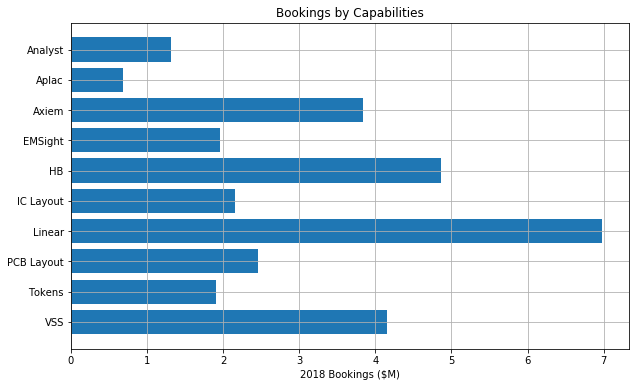

In [16]:
data = sales_by_cap.sum().sort_index(ascending=False) / 1e6
fig1 = data
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos,data, align='center')
yticks(pos, data.index)
xlabel('{} Bookings ($M)'.format(year))
title('Bookings by Capabilities')
grid(True)
show()

## Details on Specific Products

There are some new products that are interesting to track as stand-alone products.

### New Products

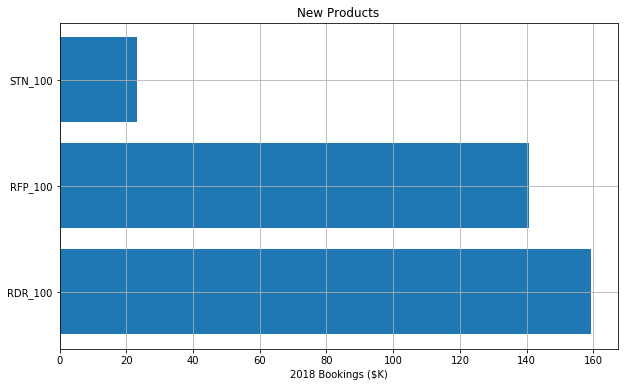

In [17]:
fig = plt.gcf()
fig.set_size_inches(10,1)  
data = sales[['RDR_100', 'RFP_100','STN_100']] / 1000
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('{} Bookings ($K)'.format(year))
title('New Products')
grid(True)
show()

### Synthesis Products

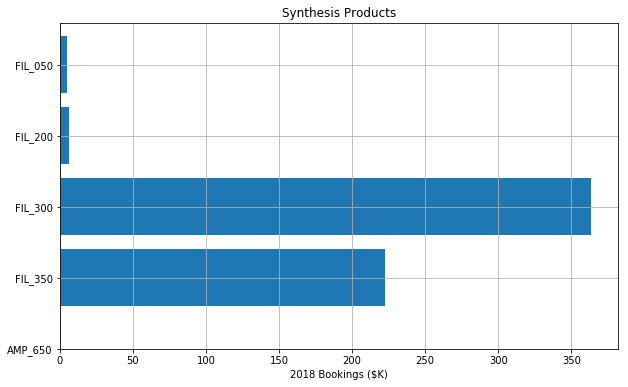

In [29]:
data = sales.reindex(['AMP_650', 'FIL_350', 'FIL_300', 'FIL_200', 'FIL_050']) / 1000
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('{} Bookings ($K)'.format(year))
title('Synthesis Products')
grid(True)
show()

### PCB Import/Export Tools

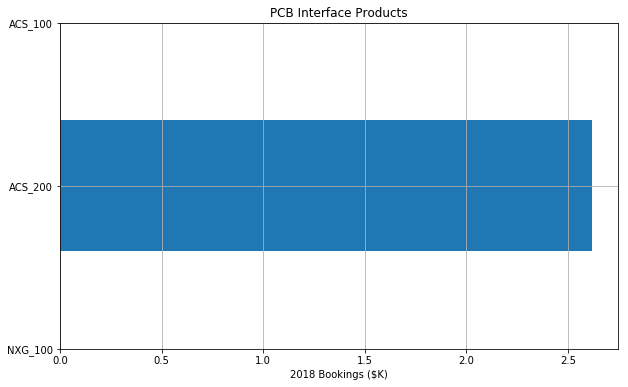

In [22]:
data = sales.reindex(['NXG_100', 'ACS_200', 'ACS_100']) / 1000  # use re-index because some zeros exist
pos = np.arange(len(data))+.5    # the bar centers on the y axis
fig = plt.gcf()
fig.set_size_inches(10,6)     
barh(pos, data, align='center')
yticks(pos, data.index)
xlabel('{} Bookings ($K)'.format(year))
title('PCB Interface Products')
grid(True)
show()

## Bookings by License Type

It is interesting to look at the bookings by license type.  The percentage of locked licenses varies from 22%-29% depending on continent but the vast majority of our licenses are floating. Currently often when we discuss our pricing we normalize all the pricing to the Locked US price but it would really make more sense to always discuss prices in terms of the Floating price since that is most of our sales. 

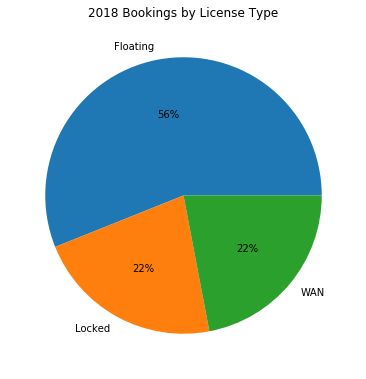

In [30]:
dl = wod.date_filter('{}-01-01'.format(year), '{}-12-31'.format(year)).sales_as_dlist()
psales15 = pd.DataFrame([x for x in dl if x['base_pn'] != 'None'])
psales15.head(10)
bt = psales15.groupby('license_type')
x=bt.agg(sum).amt_usd
plt.figure(1, figsize=(6,6))
plt.axes([0.1, 0.1, 0.8, 0.8])
plt.pie(x, labels=x.index, autopct='%1.0f%%')
plt.title('{} Bookings by License Type'.format(year))
plt.show()

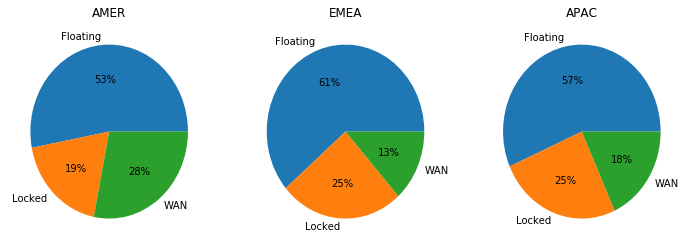

In [31]:
btc = psales15.groupby(['continent','license_type']).agg(sum).amt_usd
plt.figure(1, figsize=(12,4))
sp=1
for continent in ['AMER', 'EMEA','APAC']:
    plt.subplot(1,3,sp) # numrows, numcols, fignum
    sp += 1
    plt.pie(btc[continent], labels=btc[continent].index, autopct='%1.0f%%')
    plt.title('{}'.format(continent))
plt.show()

## Capabilities by Continent

When looking at the capabilities it is instructive to look at how sales of various capabilities compare across continents.  For this analysis the sales data by capabilities shown above is divided into continents and then normalized to the total sales in that continent.  We can therefore plot the percentage of the continent's total sales for each capability.  This will show us the geographics variation in the sales of a capability.

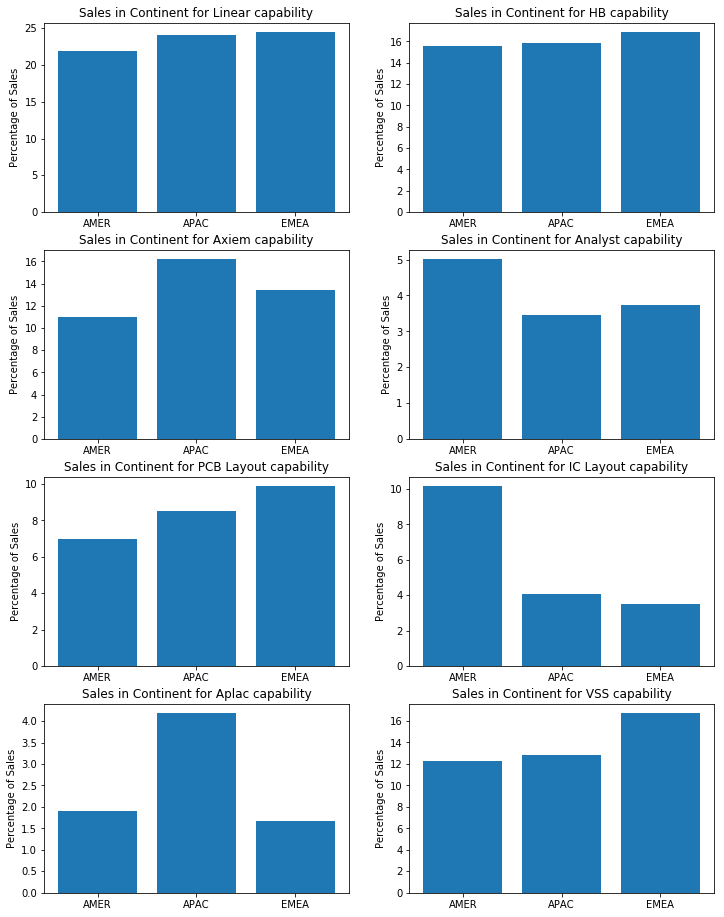

In [33]:
cap_alloc = pd.read_excel('/Users/dane/src/datatools/ipy/pn_alloc.xlsx',
             'New Allocation Methodology',
             skiprows=1, index_col=0, usecols='P:Z', header=0)
wod = sfdc.WonOppDict.read_from_file()
opps15 = wod.date_filter('{}-01-01'.format(year), '{}-12-31'.format(year)).sales_as_dlist()
df15 = pd.DataFrame(opps15)
# only keep sales for part-numbers in the allocation table
df15_subset = df15[df15.base_pn.isin(cap_alloc.index)]
# need to append the allocations to the pn table
dfm = pd.merge(df15_subset, cap_alloc, how='inner', left_on='base_pn', right_index=True)
for cap in cap_alloc.columns:
    dfm[cap] = dfm[cap] * dfm.amt_usd
cap_pct = dfm.groupby('continent').agg(sum)[list(cap_alloc.columns) + ['amt_usd']]
for cap in cap_alloc.columns:
    cap_pct[cap] = cap_pct[cap] / cap_pct.amt_usd
cap_pct = cap_pct[cap_alloc.columns]
# cap_pct = cap_pct.drop(['Comm'])
plt.figure(1, figsize=(12,16))
for i, cap in enumerate(['Linear', 'HB', 'Axiem', 'Analyst', 'PCB Layout', 'IC Layout', 'Aplac', 'VSS']):
    plt.subplot(4,2,i+1)
    data = cap_pct[cap] * 100  # covert to percentage
    pos = np.arange(len(data)) + 0.0  # offset, used to be .4 now is 0?
    plt.bar(np.arange(len(data)), data)
    plt.xticks(pos, data.index)
    plt.ylabel('Percentage of Sales')
    plt.title('Sales in Continent for {} capability'.format(cap))
plt.show()

Analyst and IC Layout are the capabilities that really stand out here with the shortfall being in Europe.  This seems to re-enforce the sentiment in Europe that the price of these products make then uncompetitive in Europe.  Hopefully the latest changes in the price list address this and we can see the sales of these products there increase to match the other continents.


# Methodology

This section goes into more details on the methodology used to allocate values to the capabilities.

The process involved the following steps, all based on the US floating price:

1. Determine the amount we charge for a capability by averaging the delta between different bundles
2. Build up a total bundle price for each of the following bundles: 106, 120, 126, 146, 186, 200, 206, 220, 226, 228, 246, 286, 288 and 449
3. Select an initial discount factor of 1-bundle_price/500,000
4. Compute the error between the computed bundle price and our list price.
5. Use the optimizer in Microwave Office to select the capability values that minimizes the error between the computed price and our list price.

The resulting values produced a maximum error of $2,700 on MWO-186.

Once the value of the capabilities and the bundle discounts were determined, the 2015 bookings data was split into it's products and the capability values for each bundle was applied to produce the total sales per capability.

The raw data for the computation is available <a href="/static/pn_alloc.xlsx">for download</a>


# Complete List of Bookings by Part Number

Well, almost complete.  I've excluded some old/eol products to shorten the list.

In [34]:
pd.options.display.max_rows = 300
exclude = ['debook ', 'IGS_002', 'LVW_100','TRN_100', 'UNV_999','MWO_025',
           'None', 'PDK_SER','APL_001','APL_002','APL_002','HWK_200']
to_display = sales[~ sales.index.isin(exclude)]
to_display.apply(lambda x: "{:,}".format(int(round(x,0))))

MWO_246    3,093,186
APL_100      369,688
MWO_200      592,583
MWO_126      606,813
MWO_226    7,117,186
MWO_225        9,956
FIL_300      363,474
MWO_100      126,432
VSS_150      226,859
VSS_250    1,535,661
MWO_228    4,013,331
HSP_100      221,271
MWO_106      802,474
MWO_248    1,252,570
XEM_100      472,361
OEA_100       68,939
ANO_228      129,779
MWO_105       30,962
FIL_050        5,006
RFP_100      140,627
VSS_350    1,899,456
MWO_205      167,651
ACE_100       74,637
MWO_101      327,434
TOK_100    1,902,450
XEM_001    1,084,192
ANA_001      386,610
STN_100       23,286
MWO_186      271,673
MWO_266       29,152
MWO_146      904,372
MWO_449      408,363
RDR_100      159,283
MDL_E30       14,834
MWO_286      853,099
HWK_300        9,241
FIL_200        6,139
SWS_100       20,547
XPW_100        1,309
TSW_100       29,373
APL_110      163,443
ANA_100       39,142
ACS_200        2,618
FIL_350      222,464
WIZ_100      214,937
RLP_449       42,587
ANA_004       38,160
ANA_040      

---
## Revisions and Updates

